In [99]:
from numpy.core.fromnumeric import size
import pandas as pd
import numpy as np
from torchvision import datasets
import pickle
import matplotlib.pyplot as plt
import torch
import cv2
import os

In [2]:
class Cell:
    def __init__(self, mask, cell_type, picture_id):
        self.mask = mask
        self.cell_type = cell_type
        self.picture_id = picture_id

In [49]:
cell_types = ['astro', 'cort', 'shsy5y']

In [79]:
def convert_to_masks(path):
    with open(path) as read_handle:
        train_data = pd.read_csv(read_handle)
    cells = {}
    for _, picture_group in train_data.groupby('id'):
        picture_id = picture_group.iloc[0]['id']
        picture_size = picture_group.iloc[0]['width'] * picture_group.iloc[0]['height']
        for index, cell in picture_group.iterrows():
            cell_array = np.zeros(picture_size, dtype=np.int8)
            annotation = [int(val) for val in cell['annotation'].split(' ')]
            cell_type = cell['cell_type']
            for index in range(0, len(annotation), 2):
                cell_array[annotation[index]:annotation[index]+annotation[index+1]].fill(1)
            if not picture_id in cells:
                cells[picture_id] = {}
                if not cell_type in cells[picture_id]:
                    cells[picture_id][cell_type] = []
            cells[picture_id][cell_type].append(Cell(cell_array, cell_type, picture_id))
    with open('./train_masks.pickle', 'wb') as save_file_handle:
        pickle.dump(cells, save_file_handle)

In [80]:
convert_to_masks('./dataset/train.csv')

In [98]:
with open('./train_masks.pickle', 'rb') as save_file_handle:
    masks = pickle.load(save_file_handle)
pictureResults = {}
for pictureId, cells in masks.items():
    result_tensor = torch.empty((520, 704, 3,))
    for cell_index, cell_type in enumerate(cell_types):
        if not cell_type in cells:
            result_tensor[:, :, cell_index].fill_(0)
            continue
        mask_arrays = cells[cell_type]
        sum_mask = mask_arrays[0].mask
        for mask in mask_arrays[1:]:
            sum_mask += mask.mask
        # REMOVE OVERLAP
        # TODO: MAKE ME FANCY
        sum_mask = np.where(sum_mask <= 1, sum_mask, 0)
        result_tensor[:, :, cell_index] = torch.from_numpy(sum_mask).view(size=(520, 704,))
    pictureResults[pictureId] = result_tensor

    

In [104]:
def writeMasks(results, root_dir = './dataset'):
    os.makedirs(os.path.join(root_dir, 'masks'), exist_ok=True)
    for image, mask in results.items():
        with open(os.path.join(root_dir, 'masks', f'{image}.pickle'), 'wb') as write_file_handle:
            pickle.dump(mask, write_file_handle)


In [105]:
writeMasks(pictureResults)

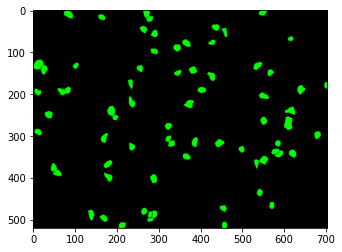

In [97]:
plt.imshow(list(pictureResults.items())[12][1])